In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

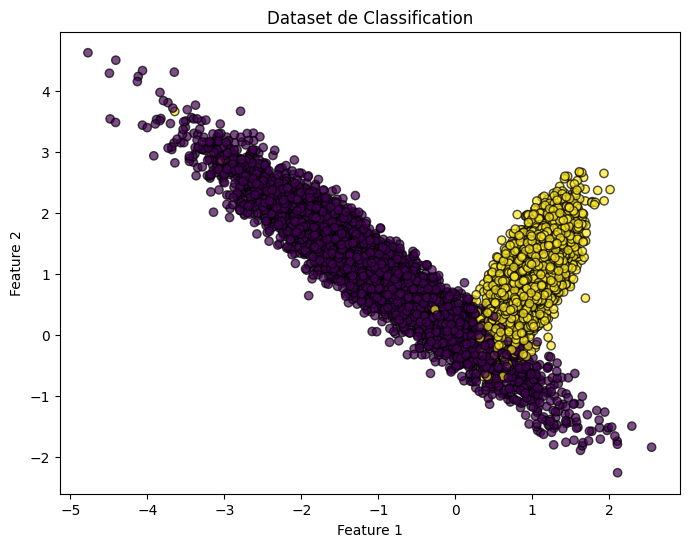

In [15]:
# Générer un dataset de classification à 2 classes
X, y = make_classification(n_samples=10000, n_features=2, n_classes=2,
                           n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Convertir en tensor pour PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Créer un DataLoader PyTorch pour l'entraînement
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualiser le dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Dataset de Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [16]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPWithDropout, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout pendant l'entraînement et l'inférence
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialiser le modèle
model = MLPWithDropout(input_dim=2, hidden_dim=10, output_dim=2)

In [17]:
import torch.optim as optim

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # En mode entraînement
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

Epoch [1/20], Loss: 0.4342528029371755
Epoch [2/20], Loss: 0.18757746265100214
Epoch [3/20], Loss: 0.13195428875878976
Epoch [4/20], Loss: 0.11070392894359252
Epoch [5/20], Loss: 0.09904012738908537
Epoch [6/20], Loss: 0.09749901123321095
Epoch [7/20], Loss: 0.09214627361014342
Epoch [8/20], Loss: 0.09147374922582231
Epoch [9/20], Loss: 0.08896418543496785
Epoch [10/20], Loss: 0.08857253593758653
Epoch [11/20], Loss: 0.08718372458449235
Epoch [12/20], Loss: 0.08734703649240085
Epoch [13/20], Loss: 0.0816859154152675
Epoch [14/20], Loss: 0.08777476501421996
Epoch [15/20], Loss: 0.08660669656196675
Epoch [16/20], Loss: 0.08734735311529697
Epoch [17/20], Loss: 0.08391198829506723
Epoch [18/20], Loss: 0.08829419459320438
Epoch [19/20], Loss: 0.08368504084512805
Epoch [20/20], Loss: 0.08347969717188432


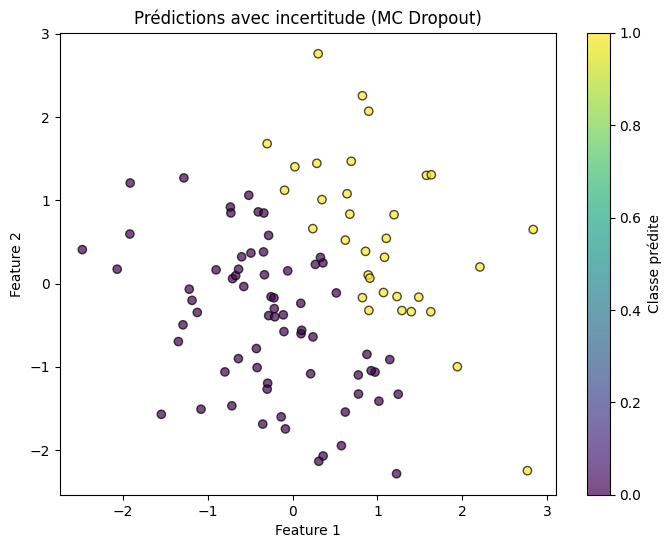

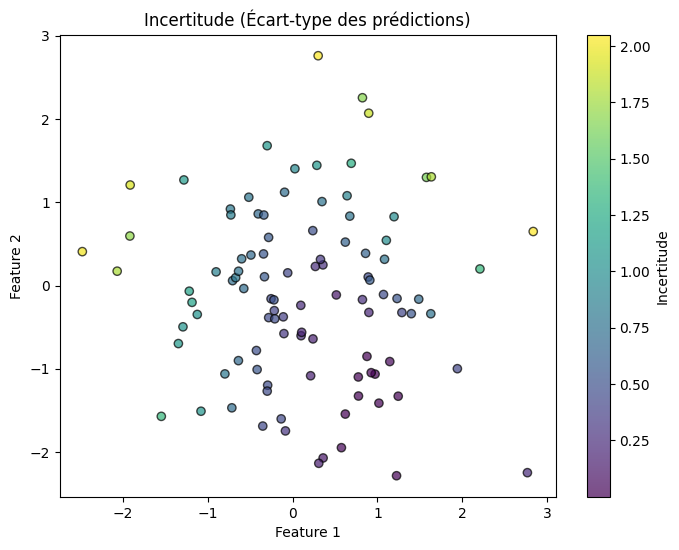

In [18]:
# Fonction pour faire des prédictions avec Dropout actif
def predict_with_uncertainty(f_model, x, n_iter=50):
    f_model.train()  # Garder Dropout actif
    preds = np.array([f_model(x).detach().numpy() for _ in range(n_iter)])
    return preds.mean(axis=0), preds.var(axis=0)

# Faire des prédictions stochastiques sur de nouvelles données
X_new = torch.randn(100, 2)  # Générer de nouvelles données aléatoires
mean_preds, var_preds = predict_with_uncertainty(model, X_new, n_iter=100)

# Visualiser les résultats
mean_probs = np.exp(mean_preds) / np.sum(np.exp(mean_preds), axis=1, keepdims=True)  # Appliquer softmax

# Tracer la prédiction moyenne et l'incertitude
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=np.argmax(mean_probs, axis=1), cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Prédictions avec incertitude (MC Dropout)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Classe prédite")
plt.show()

# Tracer l'incertitude
uncertainty = np.sqrt(var_preds)  # Calculer l'écart-type
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=uncertainty[:, 0], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Incertitude (Écart-type des prédictions)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Incertitude")
plt.show()

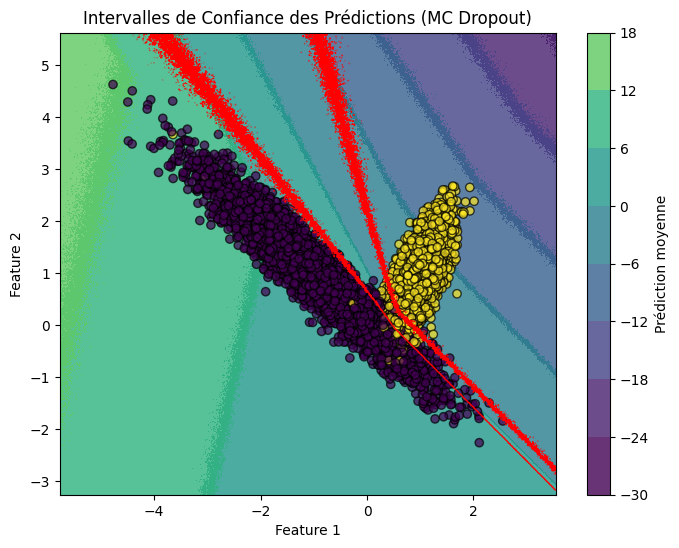

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Fonction pour faire des prédictions avec incertitude (MC Dropout)
def predict_with_uncertainty(f_model, x, n_iter=50):
    f_model.train()  # Garder Dropout actif
    preds = np.array([f_model(x).detach().numpy() for _ in range(n_iter)])
    mean_preds = preds.mean(axis=0)
    conf_interval = 1.96 * preds.std(axis=0)  # Intervalle de confiance à 95%
    return mean_preds, conf_interval

# Créer un maillage couvrant l'espace des features (plage des données)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Faire des prédictions avec incertitude sur une grille de points
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
mean_preds, conf_interval = predict_with_uncertainty(model, grid_points, n_iter=100)

# Visualiser les intervalles de confiance
plt.figure(figsize=(8, 6))

# Tracer la carte de chaleur des prédictions moyennes (inverser les couleurs)
contour = plt.contourf(xx, yy, mean_preds[:, 0].reshape(xx.shape), alpha=0.8, cmap='viridis', vmin=mean_preds.min(), vmax=mean_preds.max())

# Tracer l'intervalle de confiance à 95% (échelle de couleur)
plt.contour(xx, yy, (mean_preds[:, 0].reshape(xx.shape) + conf_interval[:, 0].reshape(xx.shape)),
            levels=[0], colors='red', linewidths=1)
plt.contour(xx, yy, (mean_preds[:, 0].reshape(xx.shape) - conf_interval[:, 0].reshape(xx.shape)),
            levels=[0], colors='red', linewidths=1)

# Afficher les points du dataset original
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)

# Ajouter la barre de couleur (échelle de couleurs)
plt.colorbar(contour, label='Prédiction moyenne')

plt.title("Intervalles de Confiance des Prédictions (MC Dropout)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
